Import libraries

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Set device

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
device

device(type='cpu')

Import MNIST

In [21]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [22]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [23]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

Visualizing data

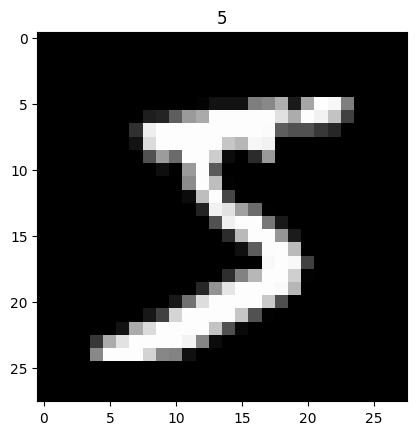

In [24]:
plt.imshow(train_dataset.data[0], cmap='gray')
plt.title('%i' % train_dataset.targets[0])
plt.show()

Define data loaders for easier data access

In [25]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
train_loader

In [27]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

Create CNN class

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        # second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        # fully connected layer
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()

        # fully connected layer
        self.fc2 = nn.Linear(128, 10)

        # softmax
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # first convolution
        x = self.pool1(self.relu1(self.conv1(x)))

        # second convolution
        x = self.pool2(self.relu2(self.conv2(x)))

        x = self.flatten(x)

        # first fully connected layer
        x = self.relu3(self.fc1(x))

        # second fully connected layer
        x = self.softmax(self.fc2(x))
        
        return x

Details about the network: 2 convolutional layers, 2 fully connected layers, 10 output classes, ReLU activation function, MaxPooling pooling, Softmax

In [29]:
model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Cross Entropy loss function

In [30]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

Optimization function with Adam's algorithm

In [31]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Training (10 epochs)

In [32]:
epochs = 10
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # reset gradients
        optimizer.zero_grad()

        # calculate output
        output = model(data)

        # find loss
        loss = loss_func(output, target)

        # backpropogate
        loss.backward()
        optimizer.step()

Testing

In [33]:
model.eval()
test_loss = 0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # calculate output
        output = model(data)

        # summate loss
        test_loss += loss_func(output, target).item()

        pred = output.argmax(dim=1)
        correct += pred.eq(target.view_as(pred)).sum().item()

        # keep track of predictions and labels for evaluation
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

Evaluation

Test Accuracy: 99.13%
Confusion Matrix:
 [[ 976    0    0    0    0    0    2    1    1    0]
 [   0 1131    2    0    0    1    0    1    0    0]
 [   2    0 1026    0    0    0    1    3    0    0]
 [   0    0    1 1007    0    1    0    1    0    0]
 [   0    0    0    0  979    0    1    0    0    2]
 [   2    0    0    6    0  881    2    0    0    1]
 [   2    2    0    0    1    4  949    0    0    0]
 [   0    1    6    2    0    1    0 1013    1    4]
 [   1    1    2    2    1    0    2    2  961    2]
 [   0    0    0    0    8    5    1    5    0  990]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99 

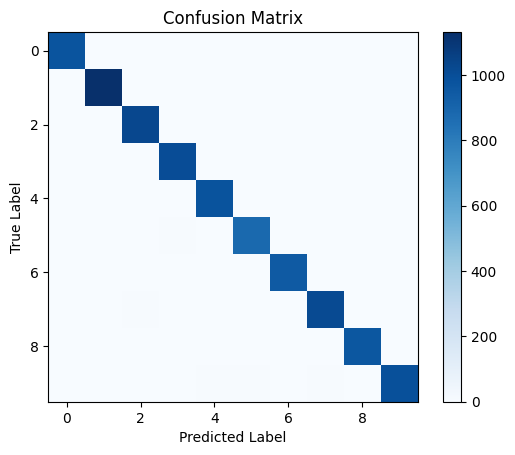

In [34]:
accuracy = correct / len(test_loader.dataset)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# generate confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()